In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

In [ ]:
dataframe = pd.read_csv("files/dataframe/pillar_data_clinvar38_annotated_final_v14_spliceai_032525.csv")

/tmp/ipykernel_2699870/84668670.py:1: DtypeWarning: Columns (4,11,13,14,15,21,22,23,34,37,38,39,40,43,44,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv("/data/dzeiberg/pillar_project/dataframe/pillar_data_clinvar38_annotated_final_v14_spliceai_032525.csv")


In [14]:
summaries_path = Path("files/model_selection_04_03_2025_P3_summaries/")
scoreset_summaries = {
    summary_file.stem.replace("_summary","") : json.load(summary_file.open())
    for summary_file in summaries_path.glob("*.json")
}

In [18]:
def assign_evidence(row, scoreset_summary):
    if scoreset_summary is None:
        return np.nan
    score = row.auth_reported_score
    if not isinstance(score,float):
        return np.nan
    pathogenic_thresholds = scoreset_summary['pathogenic_thresholds']
    benign_thresholds = scoreset_summary['benign_thresholds']
    if np.isnan(pathogenic_thresholds[0]) and np.isnan(benign_thresholds[0]): # If no evidence is met by the assay
        return 0
    elif pathogenic_thresholds[0] < benign_thresholds[0]: # assay is 'conventional'
        return get_evidence_points(score, pathogenic_thresholds, benign_thresholds, conventional=True)
    else: # assay is 'reverse'
        return get_evidence_points(score, pathogenic_thresholds, benign_thresholds, conventional=False)

def get_evidence_points(score, pathogenic_thresholds, benign_thresholds,conventional=True):
    bin2score = {0: 1,
                 1: 2,
                 2: 3,
                 3: 4,
                 4: 8}
    pathogenic_thresholds = np.array(pathogenic_thresholds)
    benign_thresholds = np.array(benign_thresholds)
    if conventional:
        exceeds_pathogenic = np.where(score <= pathogenic_thresholds)[0]
        exceeds_benign = np.where(score >= benign_thresholds)[0]
    else:
        exceeds_pathogenic = np.where(score >= pathogenic_thresholds)[0]
        exceeds_benign = np.where(score <= benign_thresholds)[0]
    if not len(exceeds_pathogenic) and not len(exceeds_benign):
        return 0
    if len(exceeds_pathogenic):
        return bin2score[exceeds_pathogenic[-1]]
    if len(exceeds_benign):
        return -1 * bin2score[exceeds_benign[-1]]

In [ ]:
from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Apply the function with progress bar
dataframe = dataframe.assign(points=dataframe.progress_apply(
    lambda row: assign_evidence(row, scoreset_summaries.get(row.Dataset, None)), axis=1) # type: ignore
)

100%|██████████| 1053714/1053714 [00:15<00:00, 68297.28it/s]


In [22]:
dataframe.points.value_counts().sort_index(ascending=False)

points
 8.0     42011
 4.0     38671
 3.0     37700
 2.0     14268
 1.0      8227
 0.0    213908
-1.0    116884
-2.0     36553
-3.0     82665
-4.0     43196
-8.0      3471
Name: count, dtype: int64

Check if we reject the fit on any dataset

In [25]:
[k for k,v in scoreset_summaries.items() if v['fit_quality_summary']['gnomAD']['0.5'] > 0.2 or \
                                    v['fit_quality_summary'].get('synonymous',{}).get('0.5',0) > 0.2]

[]

In [69]:
pd.isna(dataframe.auth_reported_func_class.values[0])

True

In [70]:
def infer_author_label(row):
    if pd.notnull(row.auth_reported_func_class):
        return row.auth_reported_func_class
    amin,amax,nmin,nmax = row.auth_reported_abnormal_min, row.auth_reported_abnormal_max, \
                            row.auth_reported_normal_min, row.auth_reported_normal_max
    score = row.auth_reported_score
    if pd.notnull(amax) and pd.notnull(nmin) and amax < nmin:
        # Assay is conventional
        if score < amax:
            return "FA"
        elif score > nmin:
            return "FN"
        else:
            return "INT"
    elif pd.notnull(amin) and pd.notnull(nmax) and amin > nmax:
        # Assay is reverse
        if score > amin:
            return "FA"
        elif score < nmax:
            return "FN"
        else:
            return "INT"
    else:
        # Cannot infer assay type
        return "UNK"

In [71]:
dataframe = dataframe.assign(inferred_author_label=dataframe.progress_apply(
    lambda row: infer_author_label(row), axis=1) # type: ignore
)

100%|██████████| 1053714/1053714 [00:22<00:00, 47589.82it/s]


# Dataset-specific comparison of author annotation vs. point assignment

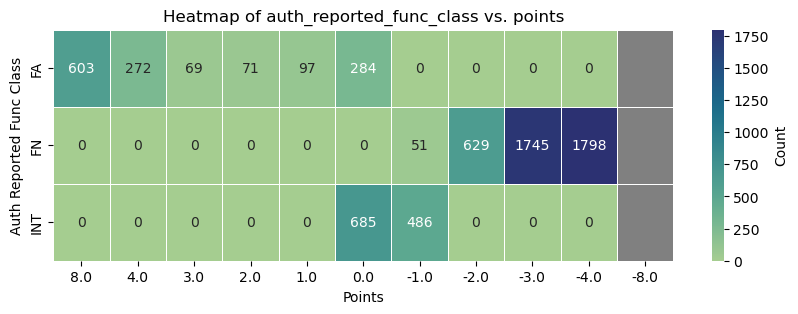

In [73]:
scoreset_name = "BRCA1_Adamovich_2022_HDR"
# Filter the dataframe
filtered_df = dataframe[
    (dataframe['Dataset'] == scoreset_name) &
    (dataframe['simplified_consequence'] == 'Missense')
]

# Create a pivot table
pivot_table = filtered_df.pivot_table(
    index='inferred_author_label',
    columns='points',
    aggfunc='size',
    fill_value=0
)
# Ensure all desired columns are present in the pivot table
desired_columns = [-8, -4, -3, -2, -1, 0, 1, 2, 3, 4, 8]
for col in desired_columns:
    if col not in pivot_table.columns:
        pivot_table[col] = 0

# Reorder the columns to match the desired order
pivot_table = pivot_table.loc[:,desired_columns]

# Plot the heatmap
plt.figure(figsize=(10, 3))

mask = np.zeros_like(pivot_table, dtype=bool)
scoreset_pathogenic_thresholds = np.array(scoreset_summaries[scoreset_name]['pathogenic_thresholds'])
scoreset_benign_thresholds = np.array(scoreset_summaries[scoreset_name]['benign_thresholds'])
for idx,threshold in enumerate(scoreset_benign_thresholds[::-1]):
    if np.isnan(threshold):
        mask[:,idx] = np.nan
for idx,threshold in enumerate(scoreset_pathogenic_thresholds,start=-5):
    if np.isnan(threshold):
        mask[:,idx] = np.nan
pivot_table = pivot_table.iloc[:,::-1]  # Reverse the order of the columns for plotting
mask = mask[:,::-1]  # Reverse the order of the mask for plotting
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(pivot_table, annot=True, cmap=cmap, mask=mask, cbar_kws={'label': 'Count'}, fmt='d',
            linewidths=0.5)
plt.gca().set_facecolor("gray")
plt.title('Heatmap of auth_reported_func_class vs. points')
plt.xlabel('Points')
plt.ylabel('Auth Reported Func Class')
plt.show()